In [95]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import time

import gc
import sys

sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1")
sys.path.append(r"E:\Research\Projects\Triangle Lattice\chiral_currents_project\Jupyter Notebooks\8Q_Triangle_Lattice_v1")

import importlib
import current_measurements.src.src_current_measurement_simulations
importlib.reload(current_measurements.src.src_current_measurement_simulations)

from current_measurements.src.src_current_measurement_simulations import CurrentMeasurementSimulation, generate_triangle_lattice_Hamiltonian


In [96]:
def add_phase(current_measurement_simulation, pair_1, pair_2, angles, print_logs=False):

    psi0 = current_measurement_simulation.psi0
    number_operators = current_measurement_simulation.number_operators

    z_1 = (number_operators[pair_1[0]] - number_operators[pair_1[1]])
    z_2 = (number_operators[pair_2[0]] - number_operators[pair_2[1]])

    unitary = (1j*(angles[0]*z_1/2 + angles[1]*z_2/2)).expm()

    if psi0.isoper:
        if print_logs:
            print('density matrix')
        psi0 = unitary @ psi0 * unitary.dag()
    elif psi0.isket:
        if print_logs:
            print('state vector')
        psi0 = unitary @ psi0

    current_measurement_simulation.psi0 = psi0
        

In [97]:
def add_x_rotation(current_measurement_simulation, pair_1, pair_2, angles, print_logs=False):

    psi0 = current_measurement_simulation.psi0
    annihilation_operators = current_measurement_simulation.annihilation_operators

    a1 = annihilation_operators[pair_1[0]]
    a2 = annihilation_operators[pair_1[1]]
    a3 = annihilation_operators[pair_2[0]]
    a4 = annihilation_operators[pair_2[1]]

    x_1 = (a1.dag()*a2 + a2.dag()*a1)
    x_2 = (a3.dag()*a4 + a4.dag()*a3)


    unitary = (1j*(angles[0]*x_1/2 + angles[1]*x_2/2)).expm()

    if psi0.isoper:
        if print_logs:
            print('density matrix')
        psi0 = unitary @ psi0 * unitary.dag()
    elif psi0.isket:
        if print_logs:
            print('state vector')
        psi0 = unitary @ psi0

    current_measurement_simulation.psi0 = psi0
        

In [131]:
num_levels = 2
num_qubits = 4
num_particles = 2

J = np.array([6, 6, 6])*2*np.pi
J_parallel = -np.array([6, 6])*2*np.pi

measurement_J = -np.array([6, 6, 10]) * 2 * np.pi

U = -180 * 2 * np.pi


times = np.linspace(0, 0.2, 101)

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]

initial_detunings = np.array([0, 0, 0, 0])*2*np.pi
measurement_detuning = np.array([300, 300, -200, -200])*2*np.pi

psi0 = -1

current_measurement_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, readout_pair_2,
                                                              initial_detunings=initial_detunings, psi0=psi0, print_logs=True, measurement_J=measurement_J, measurement_detuning=measurement_detuning)


phase_angles = [np.pi/2, np.pi/2]
# phase_angles = [0, 0]
add_phase(current_measurement_simulation, readout_pair_1, readout_pair_2, phase_angles)

x_angles = [0, 0]
add_x_rotation(current_measurement_simulation, readout_pair_1, readout_pair_2, x_angles)

current_measurement_simulation.run_simulation(True)



psi0 dims: [[2, 2, 2, 2], [1, 1, 1, 1]]
psi0 is a state vector
running simulation
running sesolve


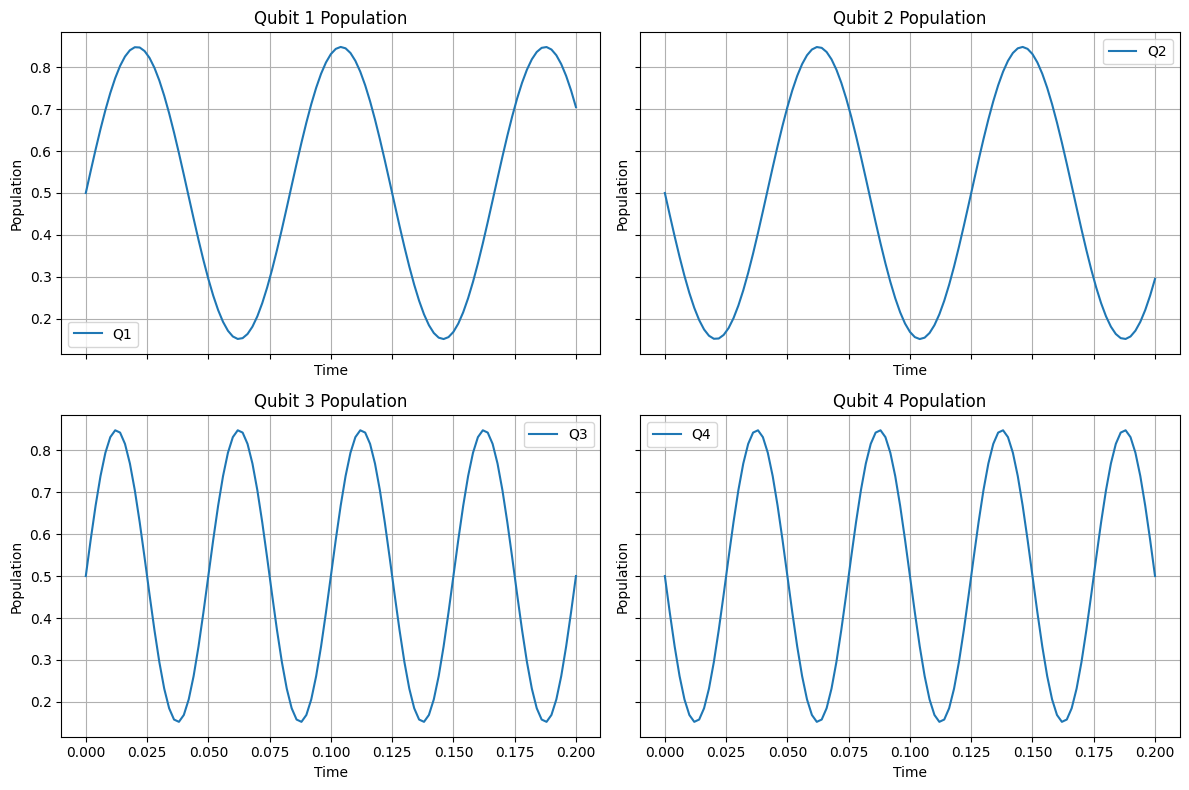

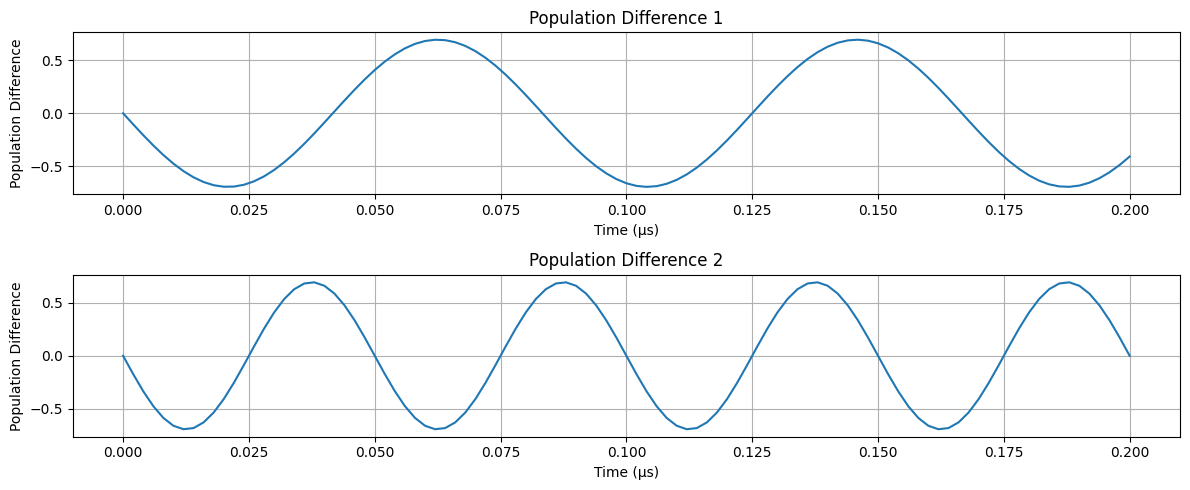

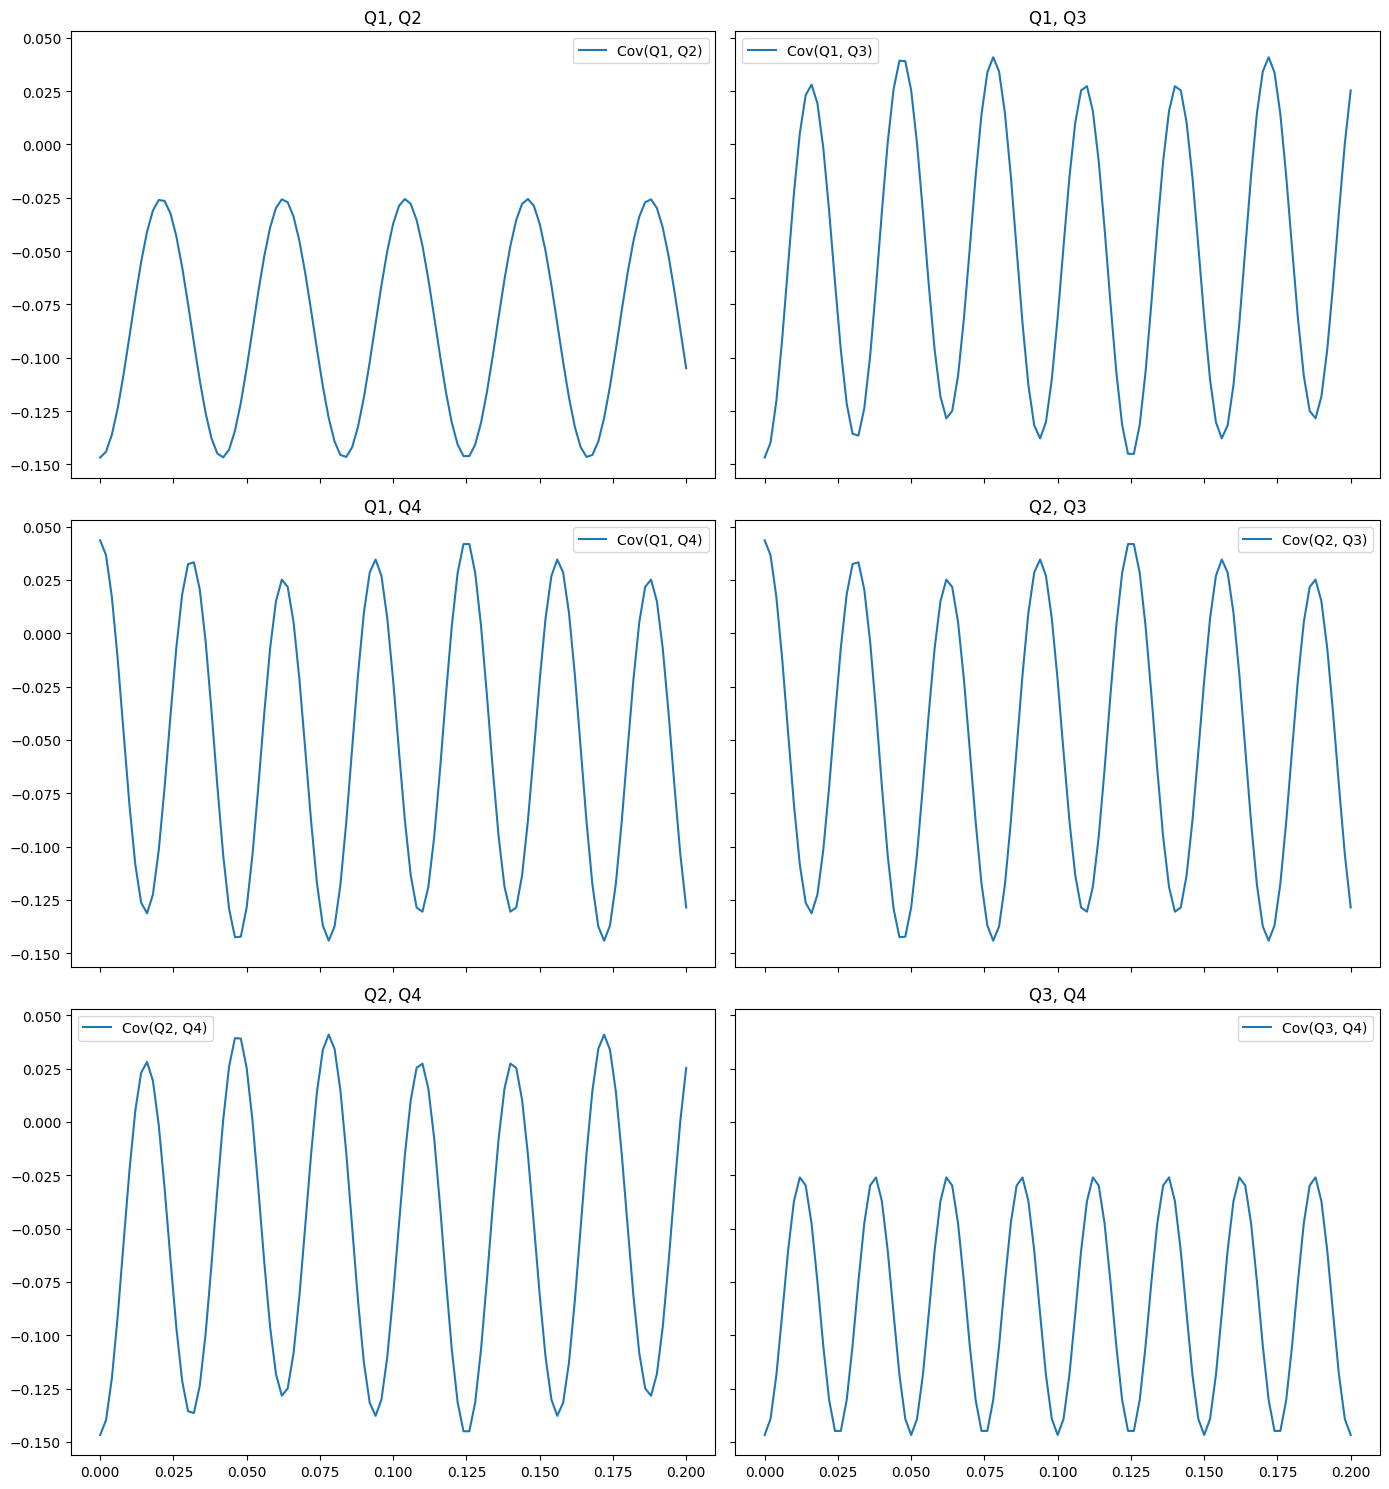

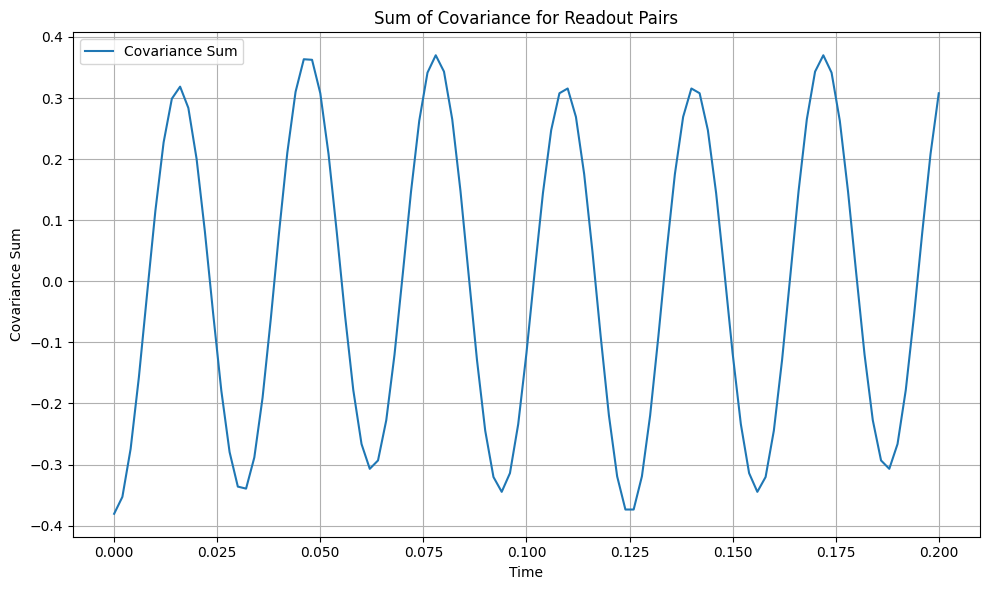

In [132]:
current_measurement_simulation.plot_populations()
current_measurement_simulation.plot_population_difference()
current_measurement_simulation.plot_covariance()
current_measurement_simulation.plot_covariance_sum()


In [133]:
psi0 = current_measurement_simulation.psi0

H = current_measurement_simulation.measurement_Hamiltonian

times = current_measurement_simulation.times

if psi0.isket:
    result = qt.sesolve(H, psi0, times)
elif psi0.isoper:
    result = qt.mesolve(H, psi0, times)

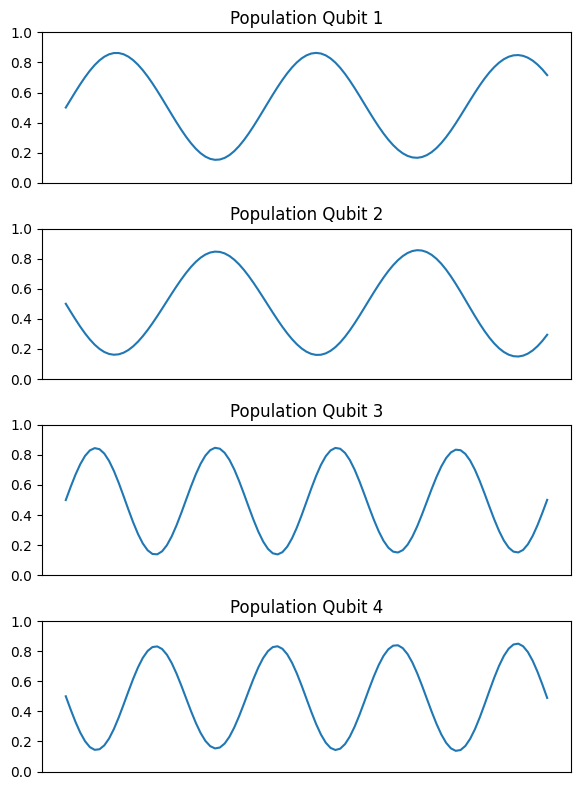

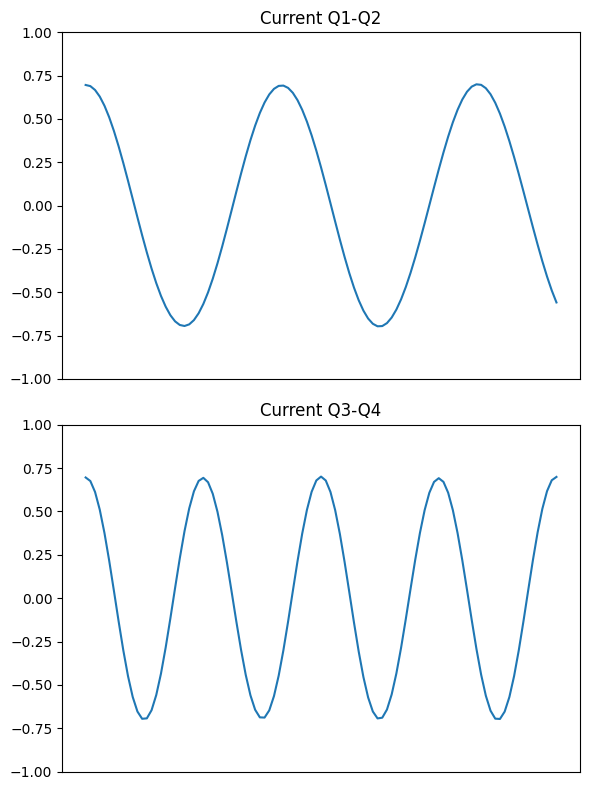

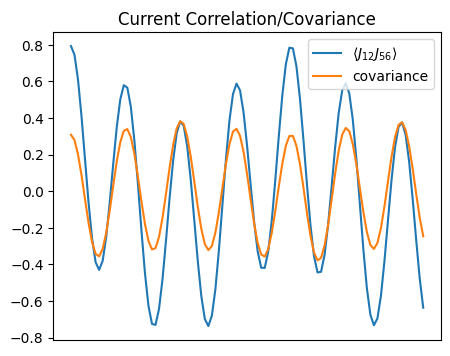

In [ ]:
states = result.states
number_operators = current_measurement_simulation.number_operators
current_operators = current_measurement_simulation.current_operators
current_correlator = current_measurement_simulation.current_correlator


### populations
populations = np.zeros((num_qubits, len(times)))
for i in range(num_qubits):
    populations[i] = [qt.expect(number_operators[i], state) for state in states]


fig, axs = plt.subplots(num_qubits, 1, figsize=(6, 8))
for i in range(num_qubits):
    axs[i].plot(times, populations[i, :])
    axs[i].set_title(f'Population Qubit {i+1}')
    axs[i].set_ylim(0, 1)
    axs[i].set_xticks([])
    axs[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

### currents 

currents = np.zeros((len(current_operators), len(times)))
for i in range(len(current_operators)):
    currents[i, :] = [qt.expect(current_operators[i], state) for state in states]


currents_normalized = currents.copy()
currents_normalized[0,:] = currents[0,:]/-J[0]
currents_normalized[1,:] = currents[1,:]/-J[-1]

fig, axs = plt.subplots(2, 1, figsize=(6, 8))
for i in range(2):
    axs[i].plot(times, currents_normalized[i, :])
    if i == 0:
        axs[i].set_title(f'Current Q1-Q2')
    elif i == 1:
        axs[i].set_title(f'Current Q3-Q4')
    axs[i].set_xticks([])
    axs[i].set_ylim(-1, 1)

plt.tight_layout()
plt.show()


### correlations

current_correlation = np.zeros(len(times))
current_covariance = np.zeros(len(times))
for i, state in enumerate(states):
    current_correlation[i] = qt.expect(current_correlator, state)
    current_covariance[i] = current_correlation[i] - currents[0, i]*currents[1, i]

current_correlation_normalized = current_correlation/(J[0]*J[-1])
current_covariance_normalized = current_covariance/(J[0]*J[-1])

plt.figure(figsize=(5, 4))
plt.plot(times, current_correlation_normalized, label=r'$\langle J_{12} J_{56}\rangle$')
plt.plot(times, current_covariance_normalized, label='covariance')
plt.legend()
plt.title('Current Covariance')
plt.xticks([])
plt.show()



### 1.1 Sweep Phase

In [81]:
num_levels = 2
num_qubits = 4
num_particles = 2

J = 6 * 2 * np.pi
J_parallel = -6*2*np.pi

U = -180 * 2 * np.pi

measurement_detunings = np.array([300, 300, -200, -200])*2*np.pi

times = np.linspace(0, 0.2, 101)

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]

initial_detunings = np.array([0, 0, 0, 0])*2*np.pi

psi0 = -1


phases = np.linspace(0, 2*np.pi, 21)
phase_2 = np.pi/2

correlation_data = np.zeros((len(phases), len(times)))

for i in range(len(phases)):

    print(f'i: {i}, phase: {phases[i]:.2f}')

    
    current_measurement_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, readout_pair_2,
                                                              initial_detunings=None, psi0=psi0)


    phase_angles = [phases[i], phase_2]
    add_phase(current_measurement_simulation, readout_pair_1, readout_pair_2, phase_angles)

    current_measurement_simulation.run_simulation(True)

    correlation_data[i,:] = current_measurement_simulation.get_covariance_sum()


    del current_measurement_simulation


i: 0, phase: 0.00
i: 1, phase: 0.31
i: 2, phase: 0.63
i: 3, phase: 0.94
i: 4, phase: 1.26
i: 5, phase: 1.57
i: 6, phase: 1.88
i: 7, phase: 2.20
i: 8, phase: 2.51
i: 9, phase: 2.83
i: 10, phase: 3.14
i: 11, phase: 3.46
i: 12, phase: 3.77
i: 13, phase: 4.08
i: 14, phase: 4.40
i: 15, phase: 4.71
i: 16, phase: 5.03
i: 17, phase: 5.34
i: 18, phase: 5.65
i: 19, phase: 5.97
i: 20, phase: 6.28


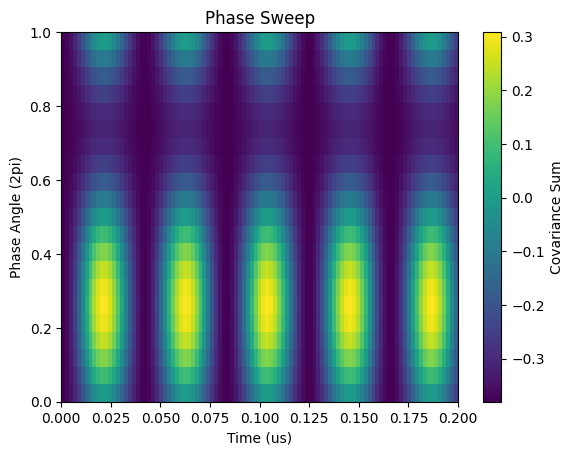

In [82]:
plt.imshow(correlation_data, interpolation='none',
           extent=(times[0], times[-1], phases[0]/2/np.pi, phases[-1]/2/np.pi), aspect='auto', origin='lower')
plt.colorbar(label='Covariance Sum')
plt.xlabel('Time (us)')
plt.ylabel('Phase Angle (2pi)')
plt.title('Phase Sweep')
plt.show()

### 1.2 Sweep X rotation

In [4]:
import psutil, os

process = psutil.Process(os.getpid())

num_levels = 2
num_qubits = 4
num_particles = 2

J = 6 * 2 * np.pi

J = [J, J, J*1.4]

J_parallel = -6*2*np.pi

U = -180 * 2 * np.pi

measurement_detunings = np.array([300, 300, -200, -200])*2*np.pi

times = np.linspace(0, 0.2, 101)

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]

initial_detunings = np.array([0, 0, 0, 0])*2*np.pi

psi0 = -1

phase_angles = [np.pi/2, 0]

x_angles = np.linspace(0, 2*np.pi, 18)
x_angles_2 = 0

correlation_data = np.zeros((len(x_angles), len(times)))

for i in range(len(x_angles)):

    print(f'iteration: {i}')
    print(x_angles[i])

    
    current_measurement_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, readout_pair_2,
                                                              initial_detunings=None, psi0=psi0)

    print('adding phase')

    add_phase(current_measurement_simulation, readout_pair_1, readout_pair_2, phase_angles)
    print('adding x rotation')
    add_x_rotation(current_measurement_simulation, readout_pair_1, readout_pair_2, [x_angles[i], x_angles_2])

    current_measurement_simulation.run_simulation(True)

    correlation_data[i,:] = current_measurement_simulation.get_covariance_sum()

    # print(correlation_data[i,:])

    # print(f"Iteration {i}, memory = {process.memory_info().rss/1e6:.1f} MB")



iteration: 0
0.0
adding phase
adding x rotation
iteration: 1
0.36959913571644626
adding phase
adding x rotation
iteration: 2
0.7391982714328925
adding phase
adding x rotation
iteration: 3
1.1087974071493387
adding phase
adding x rotation
iteration: 4
1.478396542865785
adding phase
adding x rotation


: 

In [ ]:
plt.imshow(correlation_data, interpolation='none',
           extent=(times[0], times[-1], x_angles[0]/2/np.pi, x_angles[-1]/2/np.pi), aspect='auto', origin='lower')

plt.axvline(1/(J[-1]))

plt.colorbar(label='Covariance Sum')
plt.xlabel('Time (us)')
plt.ylabel('X Rotation Angle (2pi)')
plt.title('Phase Sweep')
plt.show()

### 1.3 Sweep Coupling Strength

In [ ]:
import psutil, os
process = psutil.Process(os.getpid())

num_levels = 2
num_qubits = 4
num_particles = 2

J = 6 * 2 * np.pi
J_parallel = -6*2*np.pi

U = -180 * 2 * np.pi

measurement_detunings = np.array([300, 300, -200, -200])*2*np.pi

times = np.linspace(0, 0.2, 51)

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]

initial_detunings = np.array([0, 0, 0, 0])*2*np.pi

psi0 = -1

phase_angles = [np.pi/8, np.pi/8]
# phase_angles = [0, 0]

x_angles = [np.pi/4, 0]

couplings = np.linspace(0, 12*2*np.pi, 11)
correlation_data = np.zeros((len(couplings), len(times)))

population_data = np.zeros((4, len(couplings), len(times)))

for i in range(len(couplings)):

    print(f'iteration: {i}')
    print(couplings[i])

    J_list = [J, J, couplings[i]]

    
    print('yes')
    current_measurement_simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, readout_pair_2,
                                                              initial_detunings=None, psi0=psi0, measurement_J=J_list)

    print('adding phase')

    add_phase(current_measurement_simulation, readout_pair_1, readout_pair_2, phase_angles)
    print('adding x rotation')
    add_x_rotation(current_measurement_simulation, readout_pair_1, readout_pair_2, x_angles)

    current_measurement_simulation.run_simulation(True)

    correlation_data[i,:] = current_measurement_simulation.get_covariance_sum()

    population_data[:,i,:] = current_measurement_simulation.get_population_average()

    # print(correlation_data[i,:])

    print(f"Iteration {i}, memory = {process.memory_info().rss/1e6:.1f} MB")



In [ ]:
### plot the four populations in the first index of population_data as four colors plots on subplots 
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
axs = axs.flatten()

colors = ['r', 'g', 'b', 'm']
labels = ['Qubit 1', 'Qubit 2', 'Qubit 3', 'Qubit 4']

for idx in range(4):
    im = axs[idx].imshow(population_data[idx, :, :], aspect='auto', interpolation='none',
                        extent=[times[0], times[-1], couplings[0]/2/np.pi, couplings[-1]/2/np.pi], origin='lower')
   
    axs[idx].set_ylabel(labels[idx])
    axs[idx].set_title(f'Population of {labels[idx]}')
    axs[idx].set_ylabel('Coupling (MHz)')
    fig.colorbar(im, ax=axs[idx], label='Population')
    im.set_clim(0,1)

plt.plot(1/couplings, couplings/2/np.pi)

axs[-1].set_xlabel('Time (us)')
fig.suptitle('Populations for First Coupling Index')
# plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
plt.imshow(correlation_data, interpolation='none',
           extent=(times[0], times[-1], couplings[0]/2/np.pi, couplings[-1]/2/np.pi), aspect='auto', origin='lower')

plt.axhline(J/2/np.pi, color='red', linestyle='--', label='J')

plt.plot(2/(couplings+J), couplings/2/np.pi, color='red', label=r'half period with effective coupling  $\frac{J_{12} + J_{34}}{2}$')


plt.legend()

plt.colorbar(label='Covariance Sum')
plt.xlabel('Time (us)')
plt.ylabel('Q3-Q4 Coupling (MHz)')
plt.title('Coupling sweep Sweep')
plt.show()

In [ ]:
max_values = np.max(correlation_data, axis=1)

plt.plot(couplings/2/np.pi, max_values)